In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, microwave_coupling_matrix, generate_laser_D, generate_microwave_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [2]:
script_dir = Path().parent.absolute().parent
script_dir

WindowsPath('C:/Users/Olivier/Documents/GitHub/optical-bloch')

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Js_g = [0,1] # J values to be included

parity = lambda J: (-1)**J

# generate a list of approximate ground states
ground_states_approx = generate_coupled_ground_states(Js_g, electronic_state = 'X',
                                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                                       I_F = 1/2)
ground_states_approx = [1*state for state in ground_states_approx]

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [4]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [5]:
# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [6]:
I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1]
F1_excited = [1/2]
F_excited = [0]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for J,F1,F in zip(J_excited, F1_excited, F_excited)
                  for mF in ni_range(-F, F+1)
                 ]

Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [7]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [8]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [9]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [10]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; Q(1), F$_1$'=1/2, F'=0

In [11]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = [1*CoupledBasisState(
                                F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
                                )
                            ]

In [12]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = 1, Omega = 1)

In [13]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [14]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0

In [15]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.2902560218253714+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [16]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

## J01 microwaves

In [17]:
# Define ground states for microwaves
Js = [1]
ground_states_microwave1_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

# Define excited states for microwaves
Je = [0]
excited_states_microwave1_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Je
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

In [18]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_μ1_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=1,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**1, Omega = 0)
excited_μ1_main_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**0, Omega = 0)

In [19]:
%%time
ground_states_μ1 = find_exact_states(
                                ground_states_microwave1_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_μ1 = find_exact_states(
                                excited_states_microwave1_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_μ1_z = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ1, 
                                    excited_states = excited_states_μ1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False,
                                    nprocs = 6
                                    )
H_μ1_y = microwave_coupling_matrix(
                                    QN, 
                                    ground_states = ground_states_μ1, 
                                    excited_states = excited_states_μ1, 
                                    pol_vec = np.array([0,1,0]), 
                                    reduced = False,
                                    nprocs = 6
                                    )

Wall time: 2.52 s


In [20]:
# set small values to zero
H_μ1_z[np.abs(H_μ1_z) < 1e-3*np.max(np.abs(H_μ1_z))] = 0
H_μ1_y[np.abs(H_μ1_y) < 1e-3*np.max(np.abs(H_μ1_y))] = 0

In [21]:
ground_μ1_main = find_exact_states([ground_μ1_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_μ1_main = find_exact_states([excited_μ1_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_μ1_main = ED_ME_mixed_state(
                        ground_μ1_main, excited_μ1_main, pol_vec = np.array([0,0,1])
                        )

ground_μ1_main_idx = QN.index(ground_μ1_main)
excited_μ1_main_idx = QN.index(excited_μ1_main)

print(ME_μ1_main)
ground_μ1_main_approx.print_state()
print('-'*100)
ground_μ1_main.print_state()
print('='*100)
excited_μ1_main_approx.print_state()
print('-'*100)
excited_μ1_main.print_state()

(-0.20527689196017848+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [22]:
D_μ1 = generate_microwave_D(H_rot, QN, ground_μ1_main, excited_μ1_main, excited_states_μ1, Δ = 0)

## Total Hamiltonian

In [29]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1 + D_μ1

H_rot = np.zeros(H_rot.shape, dtype = complex)

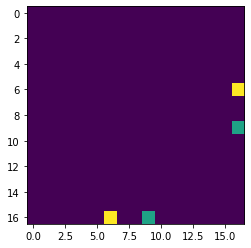

In [31]:
plt.imshow(H_laser_z_1.real)

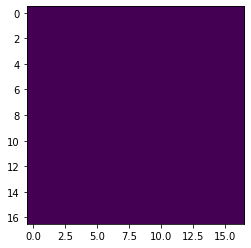

In [32]:
plt.imshow(H_rot.real)

In [33]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.29it/s]


In [34]:
Plx = Symbol("Plx(t)") # Polarization switching function for x
Plz = Symbol("Plz(t)") # Polarization switching function for z

Pμy = Symbol("Pμy(t)") # Polarization switching function for y
Pμz = Symbol("Pμz(t)") # Polarization switching function for z

laser_fields = [(H_laser_z_1*Plz, ME_main_1), (H_laser_x_1*Plx, ME_main_1), (H_μ1_y*Pμy, ME_μ1_main), (H_μ1_z*Pμz, ME_μ1_main)]
detunings = [[QN.index(excited_states[0])], [QN.index(exc) for exc in excited_states_μ1]]

In [35]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [36]:
H_symbolic = H_symbolic.subs(Ωs[0][0],Symbol('Ωl', real = True)).subs(Ωs[0][1],Symbol('Ωlᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[1][0],Symbol('Ωl', real = True)).subs(Ωs[1][1],Symbol('Ωlᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[2][0],Symbol('Ωμ', real = True)).subs(Ωs[2][1],Symbol('Ωμᶜ', real = False))
H_symbolic = H_symbolic.subs(Ωs[3][0],Symbol('Ωμ', real = True)).subs(Ωs[3][1],Symbol('Ωμᶜ', real = False))

In [37]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True, fast = True)

6it [00:00, 752.12it/s]


In [38]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [40]:
# import julia
# julia.install()

In [41]:
from julia import Main

In [42]:
Main.eval("""
#using Logging: global_logger
#using TerminalLoggers: TerminalLogger
#global_logger(TerminalLogger())

using Distributed
using BenchmarkTools
addprocs(6)

@everywhere begin
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("../utils/general_ode_functions.jl")
end
""")

In [43]:
if Main.eval("nprocs()") > 6:
    procs = Main.eval("procs()")
    procs = procs[procs > 6]
    Main.eval(f"rmprocs({procs})")

In [44]:
Main.eval("procs()")

array([1, 2, 3, 4, 5, 6], dtype=int64)

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [45]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tνlp = p[2]
\t\tΔ1 = p[3]
\t\tΩμ = p[4]
\t\tνμp = p[5]
\t\tΔ2 = p[6]

\t\tϕl = p[7]
\t\tϕμ = p[8]

\t\tΩlᶜ = conj(Ωl)
\t\tΩμᶜ = conj(Ωμ)

\t\tPlx = sine_wave(t, νlp, ϕl)
\t\tPlz = sine_wave(t, νlp, ϕl + π)
\t\tnorm1 = sqrt(Plx^2+Plz^2)
\t\tPlx /= norm1
\t\tPlz /= norm1


\t\tPμy = sine_wave(t, νμp, ϕμ)
\t\tPμz = sine_wave(t, νμp, ϕμ + π)
\t\tnorm2 = sqrt(Pμy^2+Pμz^2)
\t\tPμy /= norm2
\t\tPμz /= norm2
"""

In [46]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ωl = p[1]
		νlp = p[2]
		Δ1 = p[3]
		Ωμ = p[4]
		νμp = p[5]
		Δ2 = p[6]

		ϕl = p[7]
		ϕμ = p[8]

		Ωlᶜ = conj(Ωl)
		Ωμᶜ = conj(Ωμ)

		Plx = sine_wave(t, νlp, ϕl)
		Plz = sine_wave(t, νlp, ϕl + π)
		norm1 = sqrt(Plx^2+Plz^2)
		Plx /= norm1
		Plz /= norm1


		Pμy = sine_wave(t, νμp, ϕμ)
		Pμz = sine_wave(t, νμp, ϕμ + π)
		norm2 = sqrt(Pμy^2+Pμz^2)
		Pμy /= norm2
		Pμz /= norm2



In [47]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [48]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

### Generate density matrix

In [49]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [50]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [51]:
T = 6.3
ρ_ini = np.zeros(H_symbolic.shape, dtype = 'complex')

filled = 0
for J in range(0,2):
    p = population(J, T)
    levels = J_levels(J)
#     sl = J_slice(J)
    sl = np.s_[filled:filled+levels]
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)
    filled += levels
ρ_ini /= np.diag(ρ_ini).sum()

In [52]:
Γ = 2*np.pi * 1.56e6
Ωl = 0.1*Γ
Ωμ = 0.1*Γ
Δ1 = 0
Δ2 = 0
ωlp = 2*np.pi*1e6
ωμp = 2*np.pi*1e6

νlp = ωlp/(2*np.pi)
νμp = ωμp/(2*np.pi)

Main.Γ = Γ
Main.Ωl = Ωl
Main.νlp = νlp
Main.Δ1 = Δ1
Main.Ωμ = Ωμ
Main.νμp = νμp
Main.Δ2 = Δ2

Main.eval("ϕl = 0")
Main.eval("ϕμ = π")

Main.ρ_ini = ρ_ini

for val in 'Γ, Ωl, Ωμ, Δ1, Δ2, νlp, νμp, ϕl, ϕμ, ρ_ini'.split(","):
    Main.eval(f"@everywhere @eval {val} = ${val}")
    
# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    p = [Ωl, νlp, Δ1, Ωμ, νμp, Δ2, ϕl, ϕμ]
end
""")

In [53]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 1e-9)
tmp = 0
""")

Wall time: 7.51 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [54]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [55]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-7, dt = 1e-9)
tmp = 0
""");

Wall time: 5.57 s


0

In [56]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

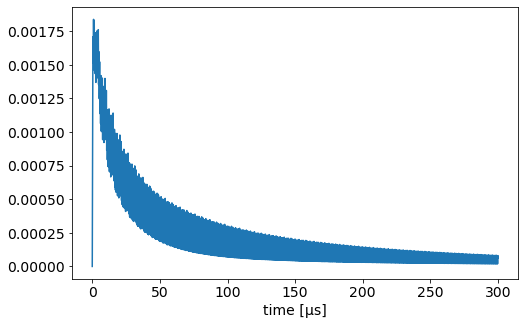

In [57]:
exc_F0 = pop_results[-1,:]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, exc_F0)

ax.set_xlabel('time [μs]')

set_fontsize(ax, 14)

In [58]:
np.trapz(exc_F0, t_array/1e6)*Γ

0.6601076401891992

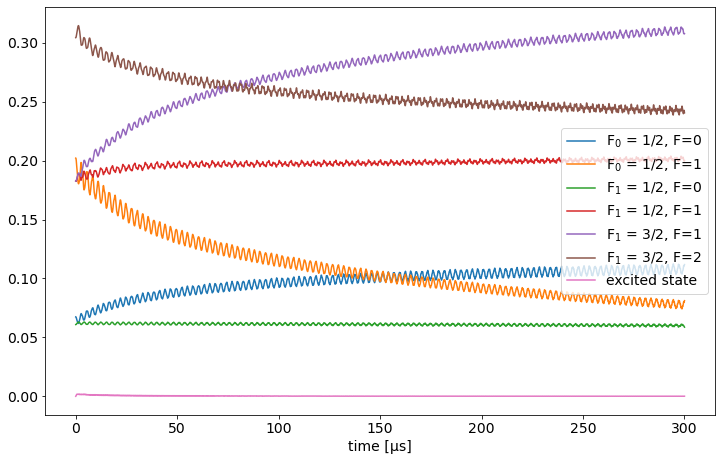

In [59]:
fig, ax = plt.subplots(figsize = (12,7.5))
ax.plot(t_array, pop_results[0,:], label = r'F$_0$ = 1/2, F=0')
ax.plot(t_array, np.sum(pop_results[1:4,:], axis = 0), label = r'F$_0$ = 1/2, F=1')

ax.plot(t_array, pop_results[4,:], label = r'F$_1$ = 1/2, F=0')
ax.plot(t_array, np.sum(pop_results[5:8,:], axis = 0), label = r'F$_1$ = 1/2, F=1')
ax.plot(t_array, np.sum(pop_results[8:11,:], axis = 0), label = r'F$_1$ = 3/2, F=1')
ax.plot(t_array, np.sum(pop_results[11:16,:], axis = 0), label = r'F$_1$ = 3/2, F=2')
ax.plot(t_array, np.sum(pop_results[-1:], axis = 0), label = 'excited state')

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Parameter scan for Δμ

In [60]:
Main.eval("""@everywhere params = [val*2π*1e6 for val in range(-5,5,length = 301)]""")

In [61]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [62]:
# p = [Ωl, νlp, Δ1, Ωμ, νμp, Δ2, ϕl, ϕμ]
Main.eval("""
@everywhere begin
    p = [0.2Γ, 1e6, 0, 0.2Γ, 1e6, 0, 0, π]
end
""")

In [63]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [64]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[0.2Γ, 1e6, 0, 0.2Γ, 1e6, params[i], 0, π])
end
""")

In [65]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [66]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

84.4313283

In [67]:
results_Δμ = np.array(Main.eval("sim.u"))

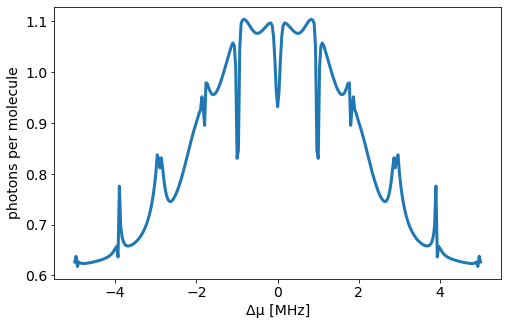

In [68]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/(2*np.pi*1e6), results_Δμ*Γ, lw = 3)
ax.set_xlabel('Δμ [MHz]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

## Parameter scan for Δμ and Ω

In [69]:
Ωs = np.linspace(0,0.5,11)*Γ 
Δμ = np.linspace(-5,5,101)*2*np.pi*1e6
params = np.array(np.meshgrid(Δμ, Ωs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [70]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,2], 1e6, 0, params[i,2], 1e6, params[i,1], 0, π])
end
""")

In [71]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [72]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

223.233436499

In [73]:
results_Δμ_Ω = np.array(Main.eval("sim.u"))

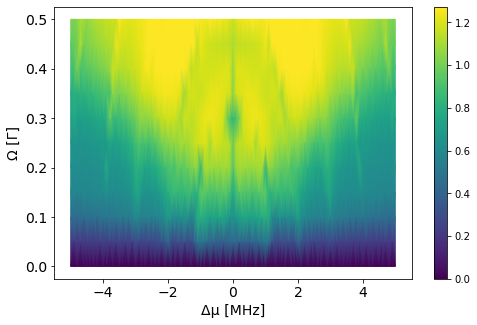

In [74]:
r = results_Δμ_Ω*Γ

fig, ax = plt.subplots(figsize = (8,5))

tcf = ax.tripcolor(params[:,0]/(2*np.pi*1e6), params[:,1]/Γ, r, shading = 'gouraud')

fig.colorbar(tcf)

ax.set_xlabel('Δμ [MHz]')
ax.set_ylabel(r'Ω [Γ]')

set_fontsize(ax, 14)

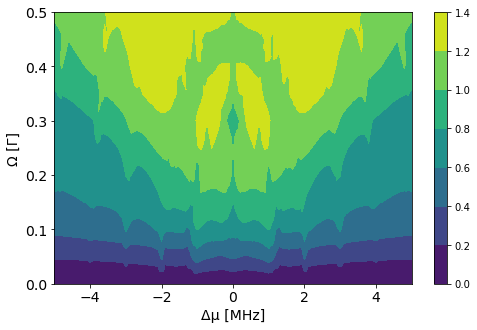

In [75]:
r = results_Δμ_Ω*Γ

fig, ax = plt.subplots(figsize = (8,5))

tcf = ax.tricontourf(params[:,0]/(2*np.pi*1e6), params[:,1]/Γ, r)

fig.colorbar(tcf)

ax.set_xlabel('Δμ [MHz]')
ax.set_ylabel(r'Ω [Γ]')

set_fontsize(ax, 14)

## Parameter scan for Δμ

In [76]:
Main.eval("""@everywhere params = [val*2π*1e6 for val in range(-5,5,length = 301)]""")

In [77]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [78]:
# p = [Ωl, νlp, Δ1, Ωμ, νμp, Δ2, ϕl, ϕμ]
Main.eval("""
@everywhere begin
    p = [0.2Γ, 0, 0, 0.2Γ, 0, 0, 0, π]
end
""")

In [79]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [80]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[0.2Γ, 0, 0, 0.2Γ, 0, params[i], 0, π])
end
""")

In [81]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [82]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

57.347089199

In [83]:
results_Δμ = np.array(Main.eval("sim.u"))

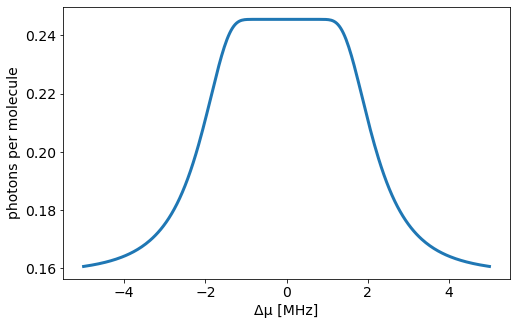

In [84]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/(2*np.pi*1e6), results_Δμ*Γ, lw = 3)
ax.set_xlabel('Δμ [MHz]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

## Parameter scan for Δμ with laser polarization switching on

In [85]:
Main.eval("""@everywhere params = [val*2π*1e6 for val in range(-5,5,length = 301)]""")

In [86]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [87]:
# p = [Ωl, νlp, Δ1, Ωμ, νμp, Δ2, ϕl, ϕμ]
Main.eval("""
@everywhere begin
    p = [0.2Γ, 1e6, 0, 0.2Γ, 0, 0, 0, π]
end
""")

In [88]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [94]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[0.2Γ, 1e6, 0, 0.2Γ, 0, params[i], 0, π])
end
""")

In [95]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [96]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

55.487760999

In [97]:
results_Δμ = np.array(Main.eval("sim.u"))

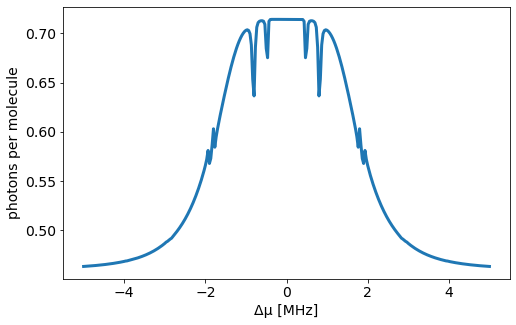

In [98]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/(2*np.pi*1e6), results_Δμ*Γ, lw = 3)
ax.set_xlabel('Δμ [MHz]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

## Parameter scan for Δμ with microwave polarization switching on

In [99]:
Main.eval("""@everywhere params = [val*2π*1e6 for val in range(-5,5,length = 301)]""")

In [100]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [101]:
# p = [Ωl, νlp, Δ1, Ωμ, νμp, Δ2, ϕl, ϕμ]
Main.eval("""
@everywhere begin
    p = [0.2Γ, 0, 0, 0.2Γ, 1e6, 0, 0, π]
end
""")

In [102]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [103]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[0.2Γ, 0, 0, 0.2Γ, 1e6, params[i], 0, π])
end
""")

In [104]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [105]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

71.648539099

In [106]:
results_Δμ = np.array(Main.eval("sim.u"))

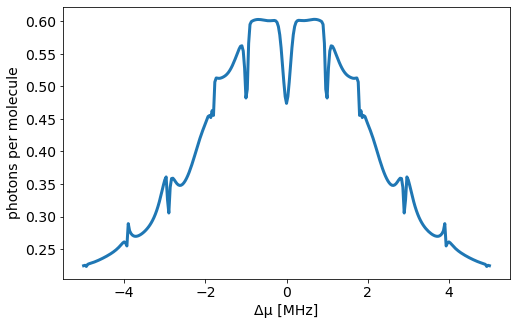

In [107]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/(2*np.pi*1e6), results_Δμ*Γ, lw = 3)
ax.set_xlabel('Δμ [MHz]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)